In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from datetime import datetime
from datetime import timedelta

# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from scipy.stats import gamma, norm

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

c:\Users\varas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


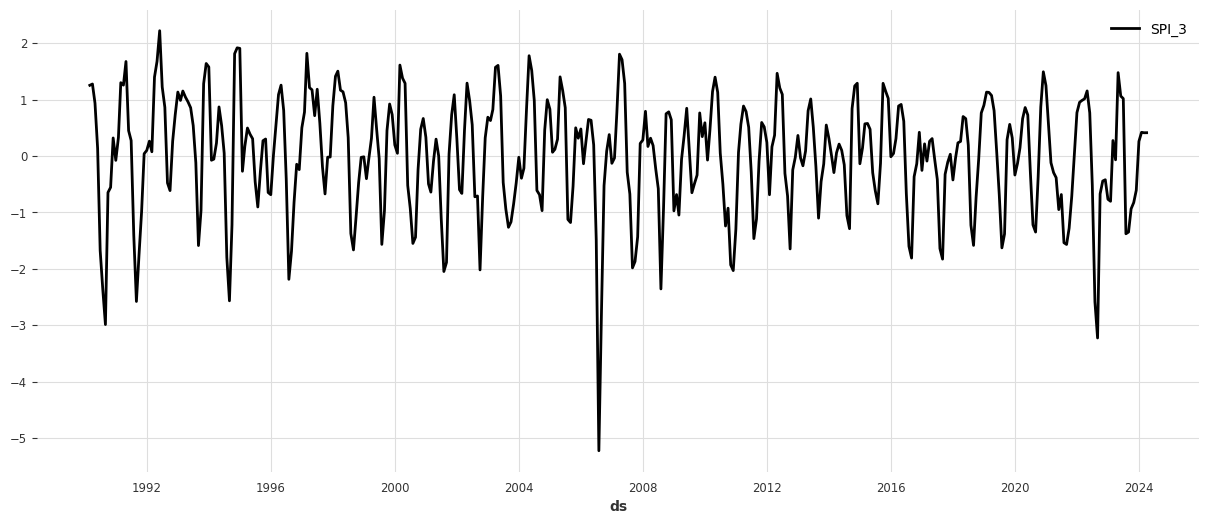

In [13]:
# df = pd.read_csv("./data/wet-bulb-temperature-hourly.csv")
# dt = [datetime.strptime(df.iloc[n,0], "%Y-%m-%d")+timedelta(hours=int(df.iloc[n,1])-1) for n in range(df.shape[0])]
# df.index = dt
# df.drop(["wbt_date","wbt_time"],axis=1,inplace=True)
df = pd.read_csv("../result/merged_data.csv")
df['data'] = pd.to_datetime(df['data'])
df['month'] = df['data'].dt.to_period('M')
df = df.sort_values(by=['station_id', 'data'])
df.head()
# Group by station and month, summing precipitation
monthly_precip = df.groupby(['station_id', 'month'])['rrr24'].sum().reset_index()
monthly_precip['month'] = monthly_precip['month'].dt.to_timestamp()
monthly_precip.rename(columns={'month': 'ds', 'rrr24': 'precip'}, inplace=True)
# monthly_precip.head()

def compute_spi(precip_series):
    precip_array = precip_series.values
    nonzero = precip_array[precip_array > 0]

    if len(nonzero) == 0:
        return np.full_like(precip_array, np.nan, dtype=float)

    # Fit gamma distribution to non-zero data
    shape, loc, scale_param = gamma.fit(nonzero, floc=0)

    # Zero probability
    zero_prob = (precip_array == 0).sum() / len(precip_array)

    # Compute SPI values
    spi_values = np.full_like(precip_array, np.nan, dtype=float)
    for i, val in enumerate(precip_array):
        if np.isnan(val):
            continue
        if val == 0:
            prob = zero_prob
        else:
            prob = zero_prob + (1 - zero_prob) * gamma.cdf(val, shape, loc, scale_param)
        # Clip to avoid extreme ppf values at 0 or 1
        prob = np.clip(prob, 1e-10, 1 - 1e-10)
        spi_values[i] = norm.ppf(prob)

    return spi_values

def compute_spi_timescales(data, col='rrr24', timescales=[1, 3, 6, 9, 12, 24]):
    spi_results = {}
    
    # for scale in timescales:
    for scale in [3]:
        # Rolling precipitation over the given scale
        rolling_precip = data[col].rolling(scale, min_periods=scale).sum()

        # Compute SPI for the rolling sum
        spi_array = compute_spi(rolling_precip)

        # Assign back to a DataFrame aligned with original index
        spi_series = pd.Series(spi_array, index=data.index, name=f"SPI_{scale}")
        spi_results[f"SPI_{scale}"] = spi_series

    return pd.DataFrame(spi_results)

all_spi_data = {}

# for station_id in monthly_precip['station_id'].unique():
for station_id in [40708]:
    station_data = monthly_precip[monthly_precip['station_id'] == station_id].copy()
    station_data = station_data.sort_values('ds').reset_index(drop=True)

    spi_df = compute_spi_timescales(station_data, col='precip')
    combined = pd.concat([station_data[['ds']], spi_df], axis=1)
    
    all_spi_data[station_id] = combined
    combined = combined.set_index('ds')  # make sure datetime is index
    series = TimeSeries.from_dataframe(combined)
    # series = TimeSeries.from_dataframe(all_spi_data[40708])
    series.plot()

In [ ]:
# # _,series = series.split_before(pd.Timestamp('20000101'))
# # series,_ = series.split_before(pd.Timestamp('20150101'))
# series, _ = series.split_before(pd.Timestamp('20150101'))

# series.plot()

ValueError: Timestamp must be between 2000-01-01 00:00:00 and 2014-12-01 00:00:00

In [23]:
train, val = series.split_before(pd.Timestamp('20150101'))

In [24]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)


In [25]:
# create hour, month and year covariate series
# year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
#                                              attribute='year', one_hot=False)
# year_series = Scaler().fit_transform(year_series)
# month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
hour_series = datetime_attribute_timeseries(series, attribute='hour', one_hot=True)
covariates = hour_series
# covariates = covariates.stack(hour_series)
cov_train, cov_val = covariates.split_before(pd.Timestamp('20200101'))


In [27]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=16,
    dropout=0,
    batch_size=16,
    n_epochs=30,
    optimizer_kwargs={'lr': 1e-3},
    model_name='Temp_RNN',
    log_tensorboard=True,
    random_state=32,
    training_length=80,
    input_chunk_length=3*24,
    force_reset=True,
    save_checkpoints=True
)

In what follows, we can just provide the whole covariates series as future_covariates argument to the model; the model will slice these covariates and use only what it needs in order to train on forecasting the target `train_transformed`:

In [28]:
my_model.fit(train_transformed,
             future_covariates=covariates,
             val_series=val_transformed,
             val_future_covariates=covariates,
             verbose=True)

Epoch 29: 100%|██████████| 14/14 [00:00<00:00, 37.10it/s, v_num=logs, train_loss=nan.0, val_loss=nan.0]


RNNModel(model=LSTM, hidden_dim=16, n_rnn_layers=1, dropout=0, training_length=80, batch_size=16, n_epochs=30, optimizer_kwargs={'lr': 0.001}, model_name=Temp_RNN, log_tensorboard=True, random_state=32, input_chunk_length=72, force_reset=True, save_checkpoints=True)

## Look at predictions on the validation set

Use the “current” model - i.e., the model at the end of the training procedure:

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


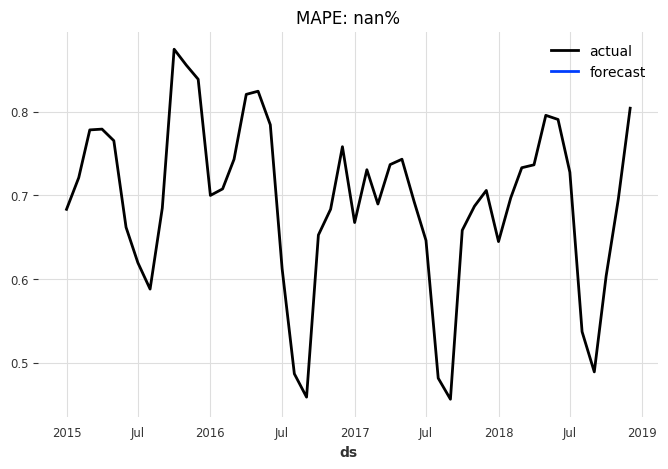

In [29]:
def eval_model(model):
    pred_series = model.predict(n=len(val), future_covariates=covariates)
    plt.figure(figsize=(8,5))
    val_transformed[:48].plot(label='actual')
    pred_series[:48].plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();

eval_model(my_model)

## Test with Linear Regression

In [30]:
from darts.models import LinearRegressionModel

LR_model = LinearRegressionModel(lags=3*24)
LR_model.fit(train)
LR_pred_series = LR_model.predict(len(val))

plt.figure(figsize=(8,5))
val[:48].plot(label='actual')
LR_pred_series[:48].plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(LR_pred_series, val)))
plt.legend();

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values